In [1]:
import torch
import numpy as np
from hysteresis.base import TorchHysteresis
from hysteresis.training import train_torch
from hysteresis.visualization import plot_hysteresis_density
import matplotlib.pyplot as plt

In [2]:
fname = 'D:/SLAC/hysteresis/magnet_characterization/strplt.ru3'

data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)
data[:, 1] = data[:, 1] / np.max(data[:, 1])
data[:, 3] = data[:, 3] * np.where(data[:,7] < 0, -1, 1)

# get real h, m
h = torch.tensor(data[:,1]).double()
m = torch.tensor(data[:,3]).double()

# normalize m
m = ((m - min(m)) / (max(m) - min(m)))*2.0 - 1.0

slope = (torch.max(m) - torch.min(m)) / \
        (torch.max(h) - torch.min(h))
scale = torch.std(m - slope * h - torch.min(m)) ** -1

def transform_m(m):
    return (m - slope * h - torch.min(m)) * scale
m = transform_m(m)

h_train = h
m_train = m

In [3]:
# fit using normal hysteresis model
H = TorchHysteresis(h_train, mesh_scale = 1.0)

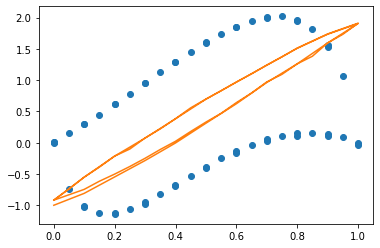

In [4]:
fig,ax = plt.subplots()
ax.plot(h_train, m_train,'o')
ax.plot(h_train, H.predict_magnetization_from_applied_fields().detach())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
tensor(0.0003, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
Parameter containing:
tensor([10.3264], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([10.3377], dtype=torch.float64, requires_grad=True)


C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_10304/1438081651.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.min(torch.tensor(loss_trace)))


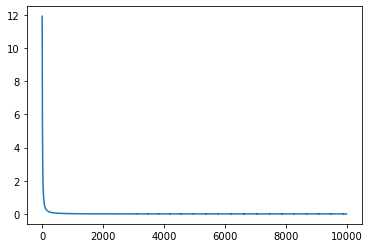

In [5]:
# train on data
loss_trace = train_torch(H, m_train, 10000, lr=0.1, atol=1e-8)
fig, ax = plt.subplots()
ax.plot(loss_trace)
print(loss_trace[-1])
print(torch.min(torch.tensor(loss_trace)))
print(H.offset)
print(H.scale)

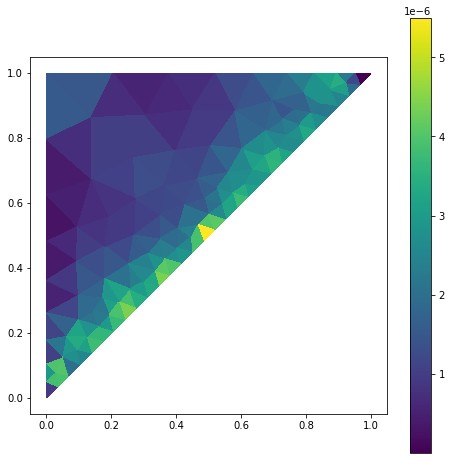

In [6]:
fig, ax = plot_hysteresis_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

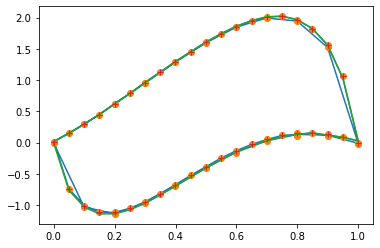

In [7]:
def fit(x):
    return 2.0*x - 1.0

fig, ax = plt.subplots()
m_pred = H.predict_magnetization_from_applied_fields()
ax.plot(h_train, m_pred.detach() )
ax.plot(h_train, m_train,'o')

m_future = H.predict_magnetization_future(h[20:])
ax.plot(h[20:], m_future.detach())
ax.plot(h[20:], m[20:],'+')


In [8]:
print(H.offset)
print(H.scale)

Parameter containing:
tensor([10.3264], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([10.3377], dtype=torch.float64, requires_grad=True)


[iteration 0001] loss: 44021746.7676
[iteration 0101] loss: 31115280.3051
[iteration 0201] loss: 19559057.0650
[iteration 0301] loss: 10612799.1545
[iteration 0401] loss: 4636669.5502
[iteration 0501] loss: 2045323.0079
[iteration 0601] loss: 978755.2275
[iteration 0701] loss: 585247.5223
[iteration 0801] loss: 305613.1429
[iteration 0901] loss: 121423.7136
[iteration 1001] loss: 29256.6748
[iteration 1101] loss: 13410.6321
[iteration 1201] loss: 10408.5169
[iteration 1301] loss: 8385.4856
[iteration 1401] loss: 8096.4680
[iteration 1501] loss: 7612.0191
[iteration 1601] loss: 7493.6526
[iteration 1701] loss: 7498.1152
[iteration 1801] loss: 7591.5921
[iteration 1901] loss: 7900.6314
[iteration 2001] loss: 7809.8595
[iteration 2101] loss: 7612.2139
[iteration 2201] loss: 7189.1249
[iteration 2301] loss: 7231.4766
[iteration 2401] loss: 7149.3500
[iteration 2501] loss: 7124.2315
[iteration 2601] loss: 7187.3159
[iteration 2701] loss: 7143.6241
[iteration 2801] loss: 7341.4710
[iteration

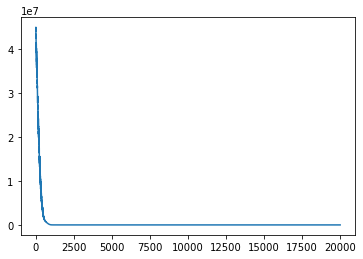

In [9]:


#train model using priors and MAP
from hysteresis.bayesian import BayesianHysteresis, positional_covariance
from hysteresis.training import map_bayes, train_bayes

def cov(model):
    return positional_covariance(model, 1.0)

bh = BayesianHysteresis(H, kernel_function=cov)
guide, trace = train_bayes(h_train, m_train, bh, 20000,initial_lr=0.01)
plt.plot(trace)


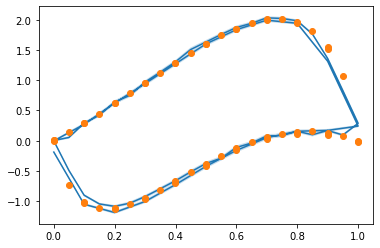

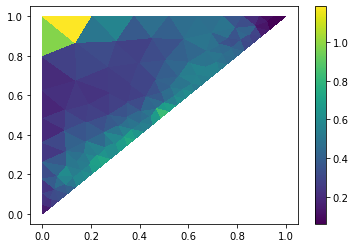

In [10]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_hysteresis_density
pred_summary, samples = predict(h_train, bh, guide)
mean = pred_summary['obs']['mean']
l = pred_summary['obs']['5%']
u = pred_summary['obs']['95%']

fig, ax = plt.subplots()
ax.plot(h_train, mean.detach())
ax.plot(h_train, m_train,'o')
ax.fill_between(h_train, l, u, alpha=0.25)


fig2, ax2 = plot_hysteresis_density(
    H,
    torch.nn.Softplus()(pred_summary['density']['mean'].flatten().detach())
)